In [1]:
from pathlib import Path

import graphviz
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics, model_selection, tree

In [2]:
PATH = Path("results/3categories")
PATH.mkdir(exist_ok=True)

In [3]:
df = pd.read_csv("data/final_train.csv", index_col=0)
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16",...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,3.355701,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0


# Data preprocessing

In [4]:
df = df.drop(columns=["subject", "void()"])
df = df.dropna()

In [5]:
df["Activity"] = df["Activity"].replace(
    {
        "STANDING": "STANDING_SITTING",
        "SITTING": "STANDING_SITTING",
        "WALKING": "WALKING_ALL",
        "WALKING_DOWNSTAIRS": "WALKING_ALL",
        "WALKING_UPSTAIRS": "WALKING_ALL",
    }
)

In [6]:
y = df["Activity"]
X = df.drop(columns=["Activity"])

In [7]:
y.value_counts()

WALKING_ALL         4261
STANDING_SITTING    3542
LAYING              1821
Name: Activity, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)

# Decision tree

In [9]:
tree_clf = tree.DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# Classification report

In [10]:
print("Test dataset accuracy:", tree_clf.score(X_test, y_test))

y_pred = tree_clf.predict(X_test)

print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification report:")
print(metrics.classification_report(y_test, y_pred))


Test dataset accuracy: 1.0
Confusion matrix:
[[ 450    0    0]
 [   0  886    0]
 [   0    0 1070]]
Classification report:
                  precision    recall  f1-score   support

          LAYING       1.00      1.00      1.00       450
STANDING_SITTING       1.00      1.00      1.00       886
     WALKING_ALL       1.00      1.00      1.00      1070

        accuracy                           1.00      2406
       macro avg       1.00      1.00      1.00      2406
    weighted avg       1.00      1.00      1.00      2406



# Tree visualization

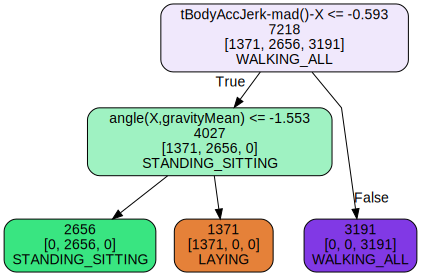

In [11]:
dot_data = tree.export_graphviz(
    tree_clf,
    feature_names=X.columns,
    class_names=tree_clf.classes_,
    label="none",
    filled=True,
    leaves_parallel=True,
    impurity=False,
    rounded=True
)
graph = graphviz.Source(dot_data)
graph.render("3categories_tree", directory=PATH, format="pdf")
graph

# Decision explaination

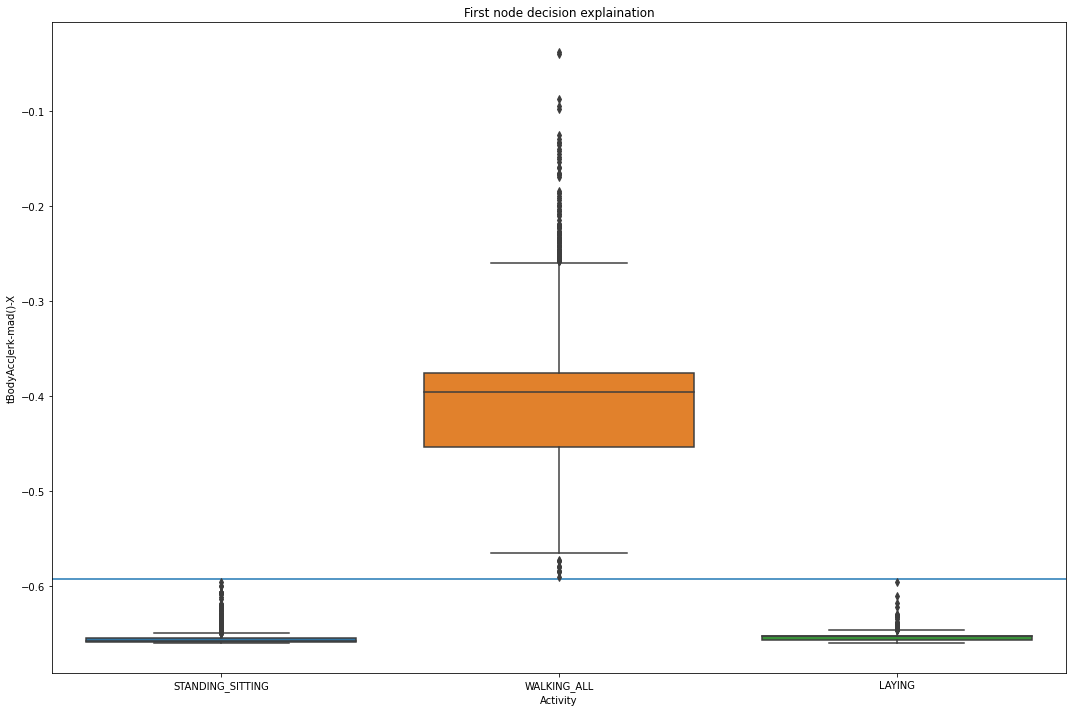

In [12]:
first_feature = X.columns[tree_clf.tree_.feature[0]]
first_threshold = tree_clf.tree_.threshold[0]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=first_feature, x=df["Activity"], data=X, ax=ax)
ax.hlines(first_threshold, *ax.get_xlim())
ax.set_title("First node decision explaination")

plt.tight_layout()
plt.show()

In [13]:
unexplained_X = X[X[first_feature] <= first_threshold]
unexplained_y = y[X[first_feature] <= first_threshold]

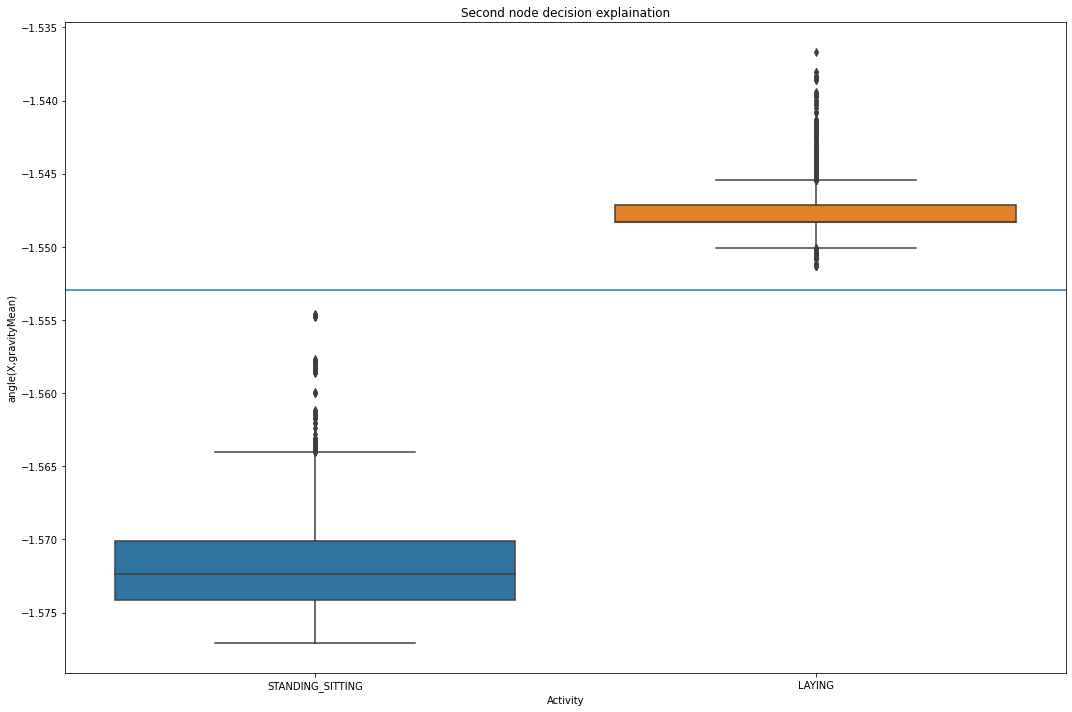

In [14]:
feature = X.columns[tree_clf.tree_.feature[1]]
threshold = tree_clf.tree_.threshold[1]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=feature, x=unexplained_y, data=unexplained_X, ax=ax)
ax.hlines(threshold, *ax.get_xlim())
ax.set_title("Second node decision explaination")

plt.tight_layout()
plt.show()

# Saving model

In [15]:
joblib.dump(tree_clf, PATH / "3categories_tree.joblib")

['results/3categories/3categories_tree.joblib']